In [1]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import os
import os.path

df = pd.read_csv(f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv", index_col=None, header=0)
df['expiration']=pd.to_datetime(df['expiration'])
df['quote_date']=pd.to_datetime(df['quote_date'])
df['delta'] = df['delta'].abs()

#########################
# Settings for backtest #
#########################
delta_sp = 0.09
delta_lp = 0.03
delta_sc = 0.09
delta_lc = 0.03

same_day = True
purchase_time = '09:45:00'

max_loss = 1.9

commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0

initial_portfolio_value = 10000
    
is_spread = False
if (delta_sp is not None and delta_lp is None) or (delta_sp is not None and delta_lp is None):
    is_spread = True


In [2]:
df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty['Date'] = pd.to_datetime(df_ty['Date'])

In [3]:
def get_contract_strike(curr_date, contract_date, i_df):
    df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
    price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
    if np.isnan(price):
        return pd.Series([0,0,0])
    rounded_price = 5 * round(price / 5)
    return pd.Series([df1['strike'],df1['delta'],rounded_price])


def get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc):
    df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')].min()
    underlying = df1['price']
    total_lost = 0.0
    if strike_sc is not None:   
        if underlying > strike_sc:
            total_lost = total_lost + (underlying - strike_sc)*100
    if strike_lc is not None:
        if underlying > strike_lc:
            total_lost = total_lost - (underlying - strike_lc)*100
    if strike_sp is not None:
        if underlying < strike_sp:
            total_lost = total_lost + (strike_sp - underlying)*100
    if strike_lp is not None:
        if underlying < strike_lp:
            total_lost = total_lost - (strike_lp - underlying)*100
    return total_lost

def get_amount_lost_minute(contract_date, strike_sp, strike_lp, strike_sc, strike_lc, curr_collected, curr_lost, curr_comm, quote_time, filtered_df):
    if curr_lost > 0.0:
        return pd.Series([curr_lost, curr_comm])
    
    if (quote_time == '16:00:00'):
        return pd.Series([get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc), curr_comm])
    
    # TODO : change this line so quote date and expiration date can be different
    df1 = filtered_df[(filtered_df['quote_date']==contract_date) & (filtered_df['expiration']==contract_date)]
    
    if strike_sp is None:
        bb_cost_sp = 0.0
    else:
        df_sp = df1[df1['strike']==strike_sp].min()
        bb_cost_sp = (df_sp['ask']+df_sp['bid'])/0.02
    
    if strike_lp is None:
        bb_cost_lp = 0.0
    else:
        df_lp = df1[df1['strike']==strike_lp].min()
        bb_cost_lp = -1*(df_lp['ask']+df_lp['bid'])/0.02
    
    if strike_sc is None:
        bb_cost_sc = 0.0
    else:
        df_sc = df1[df1['strike']==strike_sc].min()
        bb_cost_sc = (df_sc['ask']+df_sc['bid'])/0.02
    
    if strike_lc is None:
        bb_cost_lc = 0.0
    else:
        df_lc = df1[df1['strike']==strike_lc].min()
        bb_cost_lc = -1*(df_lc['ask']+df_lc['bid'])/0.02
        
    curr_cost_to_buy_back = bb_cost_sp + bb_cost_lp + bb_cost_sc + bb_cost_lc
    # return curr_value
    if curr_cost_to_buy_back >= max_loss*curr_collected:
        return pd.Series([curr_cost_to_buy_back, curr_comm*2])
    
    return pd.Series([0.0, curr_comm])

In [4]:
df_times = pd.DataFrame(df['quote_time'].unique())

df_trades = pd.DataFrame(df['expiration'].unique())
df_trades.rename({0: "expiration"}, axis='columns', inplace=True)
df_trades['trade_date'] = df_trades['expiration'].shift(1 + dte_f)
df_trades = df_trades[df_trades['trade_date'].isnull()==False]
df_trades['collected_sc'] = 0.0
df_trades['collected_lc'] = 0.0
df_trades['collected_sp'] = 0.0
df_trades['collected_lp'] = 0.0
df_trades['collected'] = 0.0
df_trades['lost'] = 0.0
df_trades['strike_sp'] = None
df_trades['strike_lp'] = None
df_trades['strike_sc'] = None
df_trades['strike_lc'] = None
df_trades['delta_sp'] = 0.0
df_trades['delta_lp'] = 0.0
df_trades['delta_sc'] = 0.0
df_trades['delta_lc'] = 0.0
df_trades['net'] = 0.0
df_trades['commission'] = 0.0
df_trades['portfolio_value'] = 0.0
df_trades['daily_return'] = 0.0
df_trades['margin_utilization']=0.0

In [5]:
trade_count = 0

# Create new filtered dataframe with only calls above target delta
if delta_sc is not None and delta_sc > 0.0:
    df_sc = df[(df['type']=="C") & (df['delta']>= delta_sc) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    df_sc = df_sc.loc[df_sc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Only keep the min expiration date for each quote
    df_sc = df_sc.loc[df_sc.groupby('quote_date')[['dte']].idxmin()['dte']]
    
    #apply dataframe to get strikes and collect premium
    df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_sc), axis = 1).T.values
    trade_count = trade_count + 1

if delta_lc is not None and delta_lc > 0.0:
    df_lc = df[(df['type']=="C") & (df['delta']>= delta_lc) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    df_lc = df_lc.loc[df_lc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Only keep the min expiration date for each quote
    df_lc = df_lc.loc[df_lc.groupby('quote_date')[['dte']].idxmin()['dte']]
    
    # apply dataframe to get strikes and collect premium
    df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_lc), axis = 1).T.values
    df_trades['collected_lc'] = df_trades['collected_lc']*-1
    trade_count = trade_count + 1

# Create new filtered dataframe with only puts above target delta
if delta_sp is not None and delta_sp > 0.0:
    df_sp = df[(df['type']=="P") & (df['delta']>= delta_sp) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
    df_sp = df_sp.loc[df_sp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Now that we're certain we have the minimum expiration date, get the minimum delta
    df_sp = df_sp.loc[df_sp.groupby('quote_date')[['dte']].idxmin()['dte']]
    df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_sp), axis = 1).T.values
    trade_count = trade_count + 1

# Create new filtered dataframe with only puts above target delta
if delta_lp is not None and delta_lp > 0.0:
    df_lp = df[(df['type']=="P") & (df['delta']>= delta_lp) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
    df_lp = df_lp.loc[df_lp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Now that we're certain we have the minimum expiration date, get the minimum delta
    df_lp = df_lp.loc[df_lp.groupby('quote_date')[['dte']].idxmin()['dte']]
    df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_lp), axis = 1).T.values
    df_trades['collected_lp']=df_trades['collected_lp']*-1
    trade_count = trade_count + 1

df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_lc'] + df_trades['collected_sp'] + df_trades['collected_lp']
df_trades['commission'] = trade_count * commission

In [6]:
df_trades.head()

,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,strike_sp,strike_lp,...,strike_lc,delta_sp,delta_lp,delta_sc,delta_lc,net,commission,portfolio_value,daily_return,margin_utilization
0,2022-01-03,2022-01-03,125.0,-25.0,125.0,-40.0,185.0,0.0,4755.0,4730.0,...,4830.0,0.0986,0.0300,0.1215,0.0304,0.0,6.0,0.0,0.0,0.0
1,2022-01-05,2022-01-05,130.0,-30.0,150.0,-45.0,205.0,0.0,4750.0,4730.0,...,4830.0,0.1073,0.0358,0.1137,0.0306,0.0,6.0,0.0,0.0,0.0
2,2022-01-07,2022-01-07,140.0,-45.0,170.0,-60.0,205.0,0.0,4655.0,4635.0,...,4760.0,0.0979,0.0388,0.0995,0.0357,0.0,6.0,0.0,0.0,0.0
3,2022-01-10,2022-01-10,190.0,-45.0,220.0,-55.0,310.0,0.0,4570.0,4540.0,...,4695.0,0.1046,0.0306,0.1102,0.0312,0.0,6.0,0.0,0.0,0.0
4,2022-01-12,2022-01-12,175.0,-45.0,210.0,-65.0,275.0,0.0,4675.0,4640.0,...,4790.0,0.1006,0.0331,0.1121,0.0350,0.0,6.0,0.0,0.0,0.0


In [7]:
for index, trow in df_times.iterrows():
    min_i = int(trow[0][3:5])
    curr_time = time(hour=int(trow[0][0:2]),minute=int(trow[0][3:5]),second=int(trow[0][6:]))
    start_time = time(hour=9, minute=45)
    end_time = time(hour=16)
    if (end_time < curr_time or curr_time <= start_time):
        continue
    filtered_df = df[(df['quote_time']==str(trow[0]))]
    df_trades['lost'], df_trades['commission'] = df_trades.apply(lambda row : get_amount_lost_minute(row['expiration'], row['strike_sp'], row['strike_lp'], row['strike_sc'], row['strike_lc'], row['collected'], row['lost'], row['commission'], str(trow[0]), filtered_df), axis=1).T.values
    
    # print(df_trades.head())
    
    if min_i % 30 == 0:
        print(f"Processed {curr_time}")

Processed 10:00:00
Processed 10:30:00
Processed 11:00:00
Processed 11:30:00
Processed 12:00:00
Processed 12:30:00
Processed 13:00:00
Processed 13:30:00
Processed 14:00:00
Processed 14:30:00
Processed 15:00:00
Processed 15:30:00
Processed 16:00:00


In [8]:
df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']

In [9]:
df_trades['portfolio_value'] = 0.0
df_trades['daily_return'] = 0.0
df_trades['margin_utilization']=0.0
initial_portfolio_value = 10000
df_trades['net_cumsum']=df_trades['net'].cumsum()

df_trades['portfolio_value'] = initial_portfolio_value + df_trades['net_cumsum']
df_trades['transaction_return'] = df_trades['net'] / df_trades['portfolio_value'].shift(1)
df_trades['transaction_return'].iloc[0] = df_trades['net'].iloc[0] / initial_portfolio_value

df_trades['cum_return'] = (df_trades['portfolio_value'] - initial_portfolio_value) / initial_portfolio_value

df_ty['daily_risk_free_return'] = (df_ty['Adj Close'] / 252) / 100
df_ty.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

df_trades = pd.merge(df_trades, df_ty, left_on='trade_date', right_on='Date')
df_trades.drop(['Date'],axis=1,inplace=True)
df_trades.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,strike_sp,strike_lp,...,delta_lc,net,commission,portfolio_value,daily_return,margin_utilization,net_cumsum,transaction_return,cum_return,daily_risk_free_return
0,2022-01-03,2022-01-03,125.0,-25.0,125.0,-40.0,185.0,377.5,4755.0,4730.0,...,0.0304,-204.5,12.0,9795.5,0.0,0.0,-204.5,-0.020450,-0.02045,0.000002
1,2022-01-05,2022-01-05,130.0,-30.0,150.0,-45.0,205.0,422.5,4750.0,4730.0,...,0.0306,-229.5,12.0,9566.0,0.0,0.0,-434.0,-0.023429,-0.04340,0.000003
2,2022-01-07,2022-01-07,140.0,-45.0,170.0,-60.0,205.0,572.5,4655.0,4635.0,...,0.0357,-379.5,12.0,9186.5,0.0,0.0,-813.5,-0.039672,-0.08135,0.000003
3,2022-01-10,2022-01-10,190.0,-45.0,220.0,-55.0,310.0,592.5,4570.0,4540.0,...,0.0312,-294.5,12.0,8892.0,0.0,0.0,-1108.0,-0.032058,-0.11080,0.000004
4,2022-01-12,2022-01-12,175.0,-45.0,210.0,-65.0,275.0,0.0,4675.0,4640.0,...,0.0350,269.0,6.0,9161.0,0.0,0.0,-839.0,0.030252,-0.08390,0.000005


In [10]:

                                                                                         
# if you want to scale the chart, you should do it here
factor = 1.0
df_trade_plot = df_trades.copy()
df_trade_plot['net'] = df_trade_plot['net']*factor
df_trade_plot.set_index('expiration', inplace=True)
df_trade_plot = df_trade_plot['net'].cumsum()

In [11]:
df_trades.tail(30)

,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,strike_sp,strike_lp,...,delta_lc,net,commission,portfolio_value,daily_return,margin_utilization,net_cumsum,transaction_return,cum_return,daily_risk_free_return
79,2022-06-10,2022-06-10,290.0,-75.0,270.0,-90.0,395.0,0.0,3865.0,3825.0,...,0.0308,389.0,6.0,14270.5,0.0,0.0,4270.5,0.028023,0.42705,0.000051
80,2022-06-13,2022-06-13,315.0,-90.0,335.0,-100.0,460.0,0.0,3710.0,3650.0,...,0.0340,454.0,6.0,14724.5,0.0,0.0,4724.5,0.031814,0.47245,0.000059
81,2022-06-14,2022-06-14,270.0,-80.0,260.0,-80.0,370.0,0.0,3665.0,3630.0,...,0.0343,364.0,6.0,15088.5,0.0,0.0,5088.5,0.024721,0.50885,0.000069
82,2022-06-15,2022-06-15,390.0,-105.0,420.0,-130.0,575.0,0.0,3660.0,3605.0,...,0.0327,569.0,6.0,15657.5,0.0,0.0,5657.5,0.037711,0.56575,0.000067
83,2022-06-16,2022-06-16,295.0,-75.0,255.0,-75.0,400.0,0.0,3605.0,3570.0,...,0.0304,394.0,6.0,16051.5,0.0,0.0,6051.5,0.025164,0.60515,0.000059
84,2022-06-17,2022-06-17,245.0,-75.0,305.0,-85.0,390.0,787.5,3620.0,3575.0,...,0.0325,-409.5,12.0,15642.0,0.0,0.0,5642.0,-0.025512,0.56420,0.000060
85,2022-06-21,2022-06-21,220.0,-55.0,260.0,-70.0,355.0,0.0,3690.0,3650.0,...,0.0349,349.0,6.0,15991.0,0.0,0.0,5991.0,0.022312,0.59910,0.000059
86,2022-06-22,2022-06-22,180.0,-65.0,210.0,-65.0,260.0,527.5,3670.0,3645.0,...,0.0377,-279.5,12.0,15711.5,0.0,0.0,5711.5,-0.017479,0.57115,0.000061
87,2022-06-23,2022-06-23,190.0,-50.0,245.0,-60.0,325.0,0.0,3720.0,3685.0,...,0.0317,319.0,6.0,16030.5,0.0,0.0,6030.5,0.020304,0.60305,0.000062
88,2022-06-24,2022-06-24,160.0,-50.0,240.0,-70.0,280.0,557.5,3785.0,3740.0,...,0.0344,-289.5,12.0,15741.0,0.0,0.0,5741.0,-0.018059,0.57410,0.000063


In [12]:
def net2pct(x):
    return (x / initial_portfolio_value)*100


def pct2net(x):
    return initial_portfolio_value * x/100



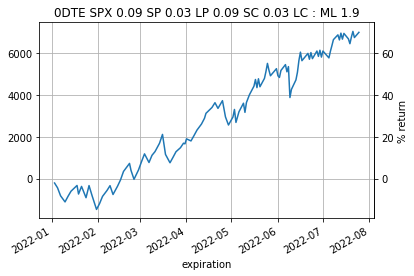

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
secax = ax.secondary_yaxis('right', functions=(net2pct, pct2net))
secax.set_ylabel('% return')
df_trade_plot.plot(ax=ax)
plt.title(f"{'0' if same_day else '1-2'}DTE SPX {delta_sp} SP {delta_lp} LP {delta_sc} SC {delta_lc} LC : ML {max_loss}")
plt.grid()
plt.savefig(f"{'0' if same_day else '1-2'}DTE_SPX_{delta_sp}SP_{delta_lp}LP_{delta_sc}SC_{delta_lc}LC_IC.png")

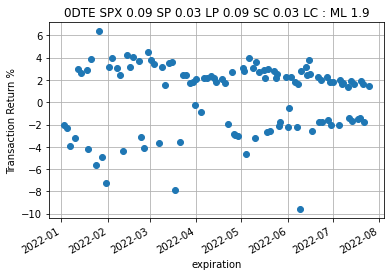

In [14]:
df_trades_transaction_return = df_trades.copy()
df_trades_transaction_return['transaction_return'] *= 100 
df_trades_transaction_return.set_index('expiration', inplace=True)
fig = plt.figure()
ax = df_trades_transaction_return['transaction_return'].plot(linestyle='None', marker="o")
ax.set_ylabel('Transaction Return %')
plt.title(f"{'0' if same_day else '1-2'}DTE SPX {delta_sp} SP {delta_lp} LP {delta_sc} SC {delta_lc} LC : ML {max_loss}")
plt.grid()
plt.savefig(f"{'0' if same_day else '1-2'}DTE_SPX_{delta_sp}SP_{delta_lp}LP_{delta_sc}SC_{delta_lc}LC_IC.png")

In [15]:
trade_count = df_trades.shape[0]
win_count = df_trades[df_trades['net']>0].shape[0]
loss_count = df_trades[df_trades['net']<0].shape[0]
std_trans_return = df_trades['transaction_return'].std()
std_trans_return_less_rf = (df_trades['transaction_return'] - df_trades['daily_risk_free_return']).std()
print("*****  BACKTEST RESULTS  ****")
print(
    f"\n{'Cumulative return:':<35}{round(df_trades['cum_return'].iloc[-1]*100,3):>10} %",
    f"\n{'Max Drawdown:':<35}{round(df_trades['cum_return'].min()*100,3):>10} %",
    
    f"\n{'Trades:':<35}{trade_count:>10}",
    f"\n{'Wins:':<35}{win_count:>10}",
    f"\n{'Losses:':<35}{loss_count:>10}",
    f"\n{'Breakeven:':<35}{df_trades[df_trades['net']==0.0].shape[0]:>10}",
    f"\n{'Win/Loss Ratio:':<35}{round(win_count/trade_count*100,3):>10} %",
    f"\n{'Mean Win:':<35}{round(df_trades[df_trades['net']>0]['net'].mean(),3):>10} $",
    f"\n{'Mean Win Trans Return:':<35}{round(df_trades[df_trades['transaction_return']>0]['transaction_return'].mean()*100,3):>10} %",
    f"\n{'Mean Loss:':<35}{round(df_trades[df_trades['net']<0]['net'].mean(),3):>10} $",
    f"\n{'Mean Loss Trans Return:':<35}{round(df_trades[df_trades['transaction_return']<0]['transaction_return'].mean()*100,3):>10} %",
    f"\n{'Mean Net Trans:':<35}{round(df_trades['net'].mean(),3):>10} $",
    f"\n{'Mean Trans Return:':<35}{round(df_trades['transaction_return'].mean()*100,3):>10} %",
    f"\n{'Std Dev of Net Trans:':<35}{round(df_trades['net'].std(),3):>10}",
    f"\n{'Std Dev of Trans Return:':<35}{round(df_trades['transaction_return'].std(),3):>10}",
    f"\n{'Max Loss:':<35}{round(df_trades['net'].min(),3):>10} $",
    f"\n{'Max Win:':<35}{round(df_trades['net'].max(),3):>10} $",
    f"\n{'Sharpe Ratio static STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return,3):>10}",
    f"\n{'Sharpe Ratio with RF STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return_less_rf,3):>10}",

)



*****  BACKTEST RESULTS  ****

Cumulative return:                      69.98 % 
Max Drawdown:                          -14.67 % 
Trades:                                   109 
Wins:                                      68 
Losses:                                    41 
Breakeven:                                  0 
Win/Loss Ratio:                        62.385 % 
Mean Win:                             332.029 $ 
Mean Win Trans Return:                   2.67 % 
Mean Loss:                             -380.0 $ 
Mean Loss Trans Return:                -3.004 % 
Mean Net Trans:                        64.202 $ 
Mean Trans Return:                      0.536 % 
Std Dev of Net Trans:                 380.626 
Std Dev of Trans Return:                0.031 
Max Loss:                             -1478.0 $ 
Max Win:                                579.0 $ 
Sharpe Ratio static STD:                 2.74 
Sharpe Ratio with RF STD:                2.74
